# T5: warm-up and cool-down phases
Script to visualize effects of warm-up and cool-down phases

In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pm4py
from datetime import datetime, timedelta
from utils import align_column_names

## Set up

In [2]:
logs = {}
log_names = [
        'P2P'
    ]

methods = {
    'asim': 'main_results',
    'wu': 'warm_up',
    'cd': 'cool_down',
    'wucd': 'warm_up_cool_down'
}

for log_name in log_names:

    logs[log_name] = {}
    
    path_sim_dir = os.path.join('..', 'data', 'simulated_data', 'threats', log_name)
    path_file = os.path.join(path_sim_dir, 'main_results', 'test_preprocessed.csv')

    # read simulated log and align column names
    test_log = pd.read_csv(path_file)
    test_log = align_column_names(test_log)
    test_log['start_timestamp'] = pd.to_datetime(test_log['start_time'], format='mixed', utc=True)
    test_log['end_timestamp']   = pd.to_datetime(test_log['end_time'], format='mixed', utc=True)

    logs[log_name]['test'] = [test_log]

    for key, method in methods.items():
        logs[log_name][key] = [] 

        path_log = os.path.join(path_sim_dir, method)
        
        for i in range(10):  # Loop through numbers 0 to 9
            path_simulated_file = os.path.join(path_log, f'simulated_log_{i}.csv')
            
            # Read simulated log and align column names
            simulated_log = pd.read_csv(path_simulated_file)
            simulated_log = align_column_names(simulated_log)

            simulated_log['start_timestamp'] = pd.to_datetime(simulated_log['start_time'], format='mixed', utc=True)
            simulated_log['end_timestamp']   = pd.to_datetime(simulated_log['end_time'], format='mixed', utc=True)

            logs[log_name][key].append(simulated_log) 

    

In [3]:
log_name = 'P2P'

## Helper functions

### Analysis

In [4]:

def calculate_waiting_times_by_freq(log_df, freq='D', use_working_hours=False, work_start=8, work_end=18):
    """
    Calculate average waiting times per specified frequency (day or week).
    Optionally calculates only within working hours.
    
    Parameters:
        log_df (pd.DataFrame): Event log data.
        freq (str): Frequency for averaging ('D' for daily, 'W' for weekly).
        use_working_hours (bool): Whether to use working hours for waiting time calculation.
        work_start (int): Hour at which the working day starts (default 8 for 8:00 AM).
        work_end (int): Hour at which the working day ends (default 18 for 6:00 PM).
        
    Returns:
        pd.DataFrame: DataFrame with average waiting times per frequency period.
    """
    def working_time_in_minutes(start, end):
        """Calculate waiting time within working hours between two timestamps."""
        total_waiting_time = timedelta(0)
        
        # Iterate through each day in the waiting time period
        current_time = start
        while current_time < end:
            if current_time.weekday() < 5:  # Monday to Friday
                workday_start = current_time.replace(hour=work_start, minute=0, second=0, microsecond=0)
                workday_end = current_time.replace(hour=work_end, minute=0, second=0, microsecond=0)
                
                # Calculate effective waiting time within work hours for the current day
                if current_time < workday_start:
                    current_time = workday_start
                if current_time > workday_end:
                    current_time += timedelta(days=1)
                    current_time = current_time.replace(hour=work_start)
                    continue
                
                day_end = min(end, workday_end)
                total_waiting_time += day_end - current_time
                current_time = day_end + timedelta(seconds=1)  # Move to the next segment
            else:
                # Move to the next day if current time is on a weekend
                current_time += timedelta(days=1)
                current_time = current_time.replace(hour=work_start)

        return total_waiting_time.total_seconds() / 60  # Convert to minutes

    waiting_times = []
    cases = log_df['case_id'].unique()
    
    for case_id in cases:
        case_events = log_df[log_df['case_id'] == case_id]
        sorted_events = case_events.sort_values('start_timestamp')
        
        for i in range(1, len(sorted_events)):
            start = sorted_events.iloc[i - 1]['end_timestamp']
            end = sorted_events.iloc[i]['start_timestamp']
            
            # Use working time calculation if enabled, else use total elapsed time
            if use_working_hours:
                waiting_time_minutes = working_time_in_minutes(start, end)
            else:
                waiting_time_minutes = (end - start).total_seconds() / 60  # Total elapsed time in minutes
            
            waiting_times.append({
                'timestamp': sorted_events.iloc[i]['start_timestamp'],
                'waiting_time_minutes': waiting_time_minutes
            })
    
    waiting_times_df = pd.DataFrame(waiting_times)
    
    # Resample the data based on the specified frequency
    waiting_times_df.set_index('timestamp', inplace=True)
    avg_waiting_times = waiting_times_df.resample(freq).mean().reset_index()
    
    return avg_waiting_times


In [5]:
def get_waiting_times(log_df, freq='D'):
    tf_df = pm4py.extract_temporal_features_dataframe(log_df, grouper_freq=freq, activity_key='activity', case_id_key='case_id', 
                                                                    timestamp_key='end_timestamp', start_timestamp_key='start_timestamp', resource_key='resource')
    tf_df['waiting_time_minutes'] = tf_df['average_waiting_time']/60/60

    return tf_df[['timestamp', 'waiting_time_minutes']]    

In [6]:
def average_waiting_times(logs_list, freq='D', use_working_hours=False, calc_method='custom'):
    """
    Average waiting times for a list of logs based on the specified frequency.
    
    Parameters:
        logs_list (list): List of DataFrames for each log.
        freq (str): Frequency for averaging ('D' for daily, 'W' for weekly).
        use_working_hours (bool): Whether to use working hours for waiting time calculation.
        calc_method (str): The method to use for calculation ('custom' or 'pm4py').
        
    Returns:
        pd.DataFrame: DataFrame containing averaged waiting times.
    """
    all_waiting_times = []

    for log_df in logs_list:
        if calc_method == 'custom':
            waiting_times = calculate_waiting_times_by_freq(log_df, freq=freq, use_working_hours=use_working_hours)
        elif calc_method == 'pm4py':
            waiting_times = get_waiting_times(log_df, freq=freq)

        all_waiting_times.append(waiting_times)

    # Concatenate all waiting times into a single DataFrame
    combined_waiting_times = pd.concat(all_waiting_times)
    
    # Average the waiting times based on the timestamp
    averaged_waiting_times = combined_waiting_times.groupby('timestamp', as_index=False).mean()

    return averaged_waiting_times

### Plotting

In [7]:
def get_label(label):
    lookup = {
        'test_preprocessed': 'Test log',
        'main_results': '(i) regular simulation',
        'warm_up': '(ii) pre-warm-up',
        'cool_down': '(iii) post-cool-down',
        'warm_up_cool_down': '(iv) pre-warm-up & \n      post-cool-down'
    }
    label = lookup[label]
    return label

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_waiting_times_for_log(log_name, logs, methods, freq='D', use_working_hours=False, calc_method='custom', marker_interval=3):
    """
    Plot average waiting times for different methods of a single log.
    
    Parameters:
        log_name (str): The name of the log to plot.
        logs (dict): Dictionary containing event logs for each log_name and method.
        methods (dict): Dictionary mapping method keys to their descriptive names.
        freq (str): Frequency for averaging ('D' for daily, 'W' for weekly).
        marker_interval (int): Interval to place markers along the lines.
    """
    # Define font sizes
    label_fontsize = 18
    title_fontsize = 20
    tick_fontsize = 16
    # legend_fontsize = 16
    legend_fontsize = 14
    linewidth = 3
    dpi = 600
    # figsize = (10, 4.5)
    figsize = (8, 3.5)

    # Define markers
    markers = ['o', 's', '^', 'D', 'p']  # Circle, Square, Triangle, Diamond, Plus

    # Create figure
    plt.figure(figsize=(figsize))

    # Initialize the list for custom legend elements
    legend_elements = []

    # Color cycle for different lines (ensure different colors for different methods)
    color_cycle = plt.cm.tab10.colors  # This gives a set of 10 different colors.

    for idx, (key, method) in enumerate([("test", "test_preprocessed"), *methods.items()]):
        
        # Calculate averaged waiting times using the new function
        averaged_waiting_times = average_waiting_times(logs[log_name][key], freq=freq, use_working_hours=use_working_hours, calc_method=calc_method)

        # Select the marker and color for this method based on the index
        marker = markers[idx % len(markers)]
        color = color_cycle[idx % len(color_cycle)]  # Ensure unique colors for each method

        # Plotting the average waiting times (line only, no markers)
        line, = plt.plot(
            averaged_waiting_times['timestamp'], 
            averaged_waiting_times['waiting_time_minutes'], 
            label=f"{get_label(method)}", marker='', markersize=6, linestyle='-', color=color, linewidth=linewidth
        )

        # Add markers at every X-th interval (only plot the markers at the specified interval)
        plt.plot(
            averaged_waiting_times['timestamp'][::marker_interval], 
            averaged_waiting_times['waiting_time_minutes'][::marker_interval], 
            linestyle='', marker=marker, markersize=6, color=color  # Add markers with the same color as the line
        )

        # Manually create a legend entry for the line (with marker) (same handle)
        legend_elements.append(Line2D([0], [0], color=color, lw=2, marker=marker, markersize=6, label=f"{get_label(method)}"))

    # Apply font sizes
    plt.xlabel('Dates', fontsize=label_fontsize)
    plt.ylabel('Average waiting time', fontsize=label_fontsize)  # (minutes)
    title = f'Average Waiting Times for {log_name} ({freq}-level)'
    print(title)

    # Add legend with custom elements (lines + markers)
    plt.legend(handles=legend_elements, fontsize=legend_fontsize, loc='lower right', bbox_to_anchor=(0.975, -0.035))#, ncol=2)

    # Set x-ticks with only every second label
    x_ticks = plt.gca().get_xticks()
    plt.xticks(x_ticks[::2], fontsize=tick_fontsize)  # Display every second tick

    y_ticks = plt.gca().get_yticks()
    plt.yticks(y_ticks[::2], fontsize=tick_fontsize)

    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Adjust layout to prevent overlap
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    figure_name = 't5_p2p_waiting.pdf'
    output_path = os.path.join('..', 'figures', figure_name)
    plt.savefig(output_path, dpi=dpi, format='pdf', bbox_inches='tight')

    plt.show()


## Visualization of waiting times

Average Waiting Times for P2P (W-level)


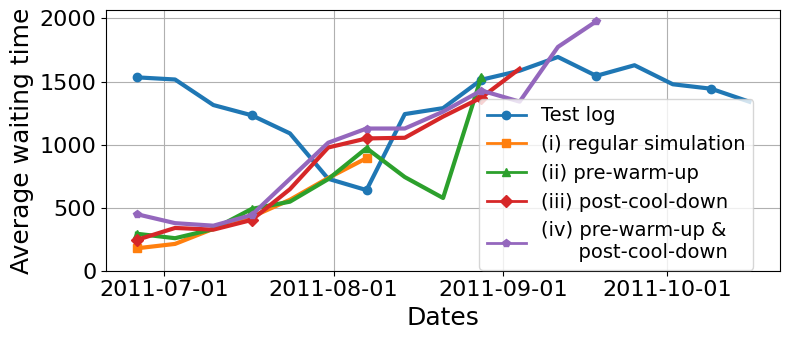

In [9]:
plot_waiting_times_for_log('P2P', logs, methods, freq='W', use_working_hours=True, calc_method='pm4py')